In [1]:
# %%
from pathlib import Path
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# %% Check XGBoost version
def versiontuple(v):
    return tuple(map(int, (v.split("."))))
print(f'{xgb.__version__=}')
assert versiontuple(xgb.__version__) >= versiontuple("2.1.1")


xgb.__version__='2.1.1'


In [3]:
# %% Find data folder
def find_directory(target_dir):
    return next((p / target_dir for p in Path.cwd().parents if (p / target_dir).is_dir()), None) or Path(target_dir)

# Define the path to the data folder
data_dir = find_directory('data') or Path('data')
print(f'{data_dir=}')


data_dir=PosixPath('/home/msugar_dsi_2024_08_gmail_com/team_3_project/data')


In [4]:
# %% Load the data
raw_data_dir = data_dir / 'raw'
train_data = pd.read_csv(raw_data_dir / 'Training.csv') 
test_data = pd.read_csv(raw_data_dir / 'Testing.csv')


In [5]:
# %% Drop unnamed last column containing all NaNs
train_data.dropna(how='all', axis='columns', inplace=True)
assert train_data.shape == (4920,133), "Training data should have 4920 rows and 133 cols after all NaNs col is removed"
print(train_data.columns)


Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)


In [6]:
# %%
# Separate features and labels
label_col = "prognosis"
X_train = train_data.drop(label_col, axis=1)
y_train = train_data[label_col]
X_test = test_data.drop(label_col, axis=1)
y_test = test_data[label_col]


In [7]:
# %%
# Encode the disease labels into numerical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [8]:
# %%
# Define the XGBoost classifier with multi-label strategy
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))

# Train the model
xgb_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = xgb_model.predict(X_test)


In [9]:
# %%
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report for detailed performance metrics
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.98
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       0.50      1.00      0.67         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1.00      1.00         1
            

In [10]:
# %%
# Feature importance analysis
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Top 10 Important Features Overall:")
print(feature_importance_df.head(10))
print()
print("Top 10 Unimportant Features Overall:")
print(feature_importance_df.tail(10))


Top 10 Important Features Overall:
                         Feature  Importance
96                  irritability    0.063654
59   pain_during_bowel_movements    0.037458
65                        cramps    0.037454
125                 skin_peeling    0.037453
129                      blister    0.037452
78                     knee_pain    0.037410
46           swelling_of_stomach    0.032990
107                mucoid_sputum    0.032821
92              passage_of_gases    0.032797
94           toxic_look_(typhos)    0.032795

Top 10 Unimportant Features Overall:
                  Feature  Importance
72          brittle_nails         0.0
105              polyuria         0.0
120          palpitations         0.0
55             congestion         0.0
18            mood_swings         0.0
17   cold_hands_and_feets         0.0
16                anxiety         0.0
45         fluid_overload         0.0
114      stomach_bleeding         0.0
42           yellow_urine         0.0


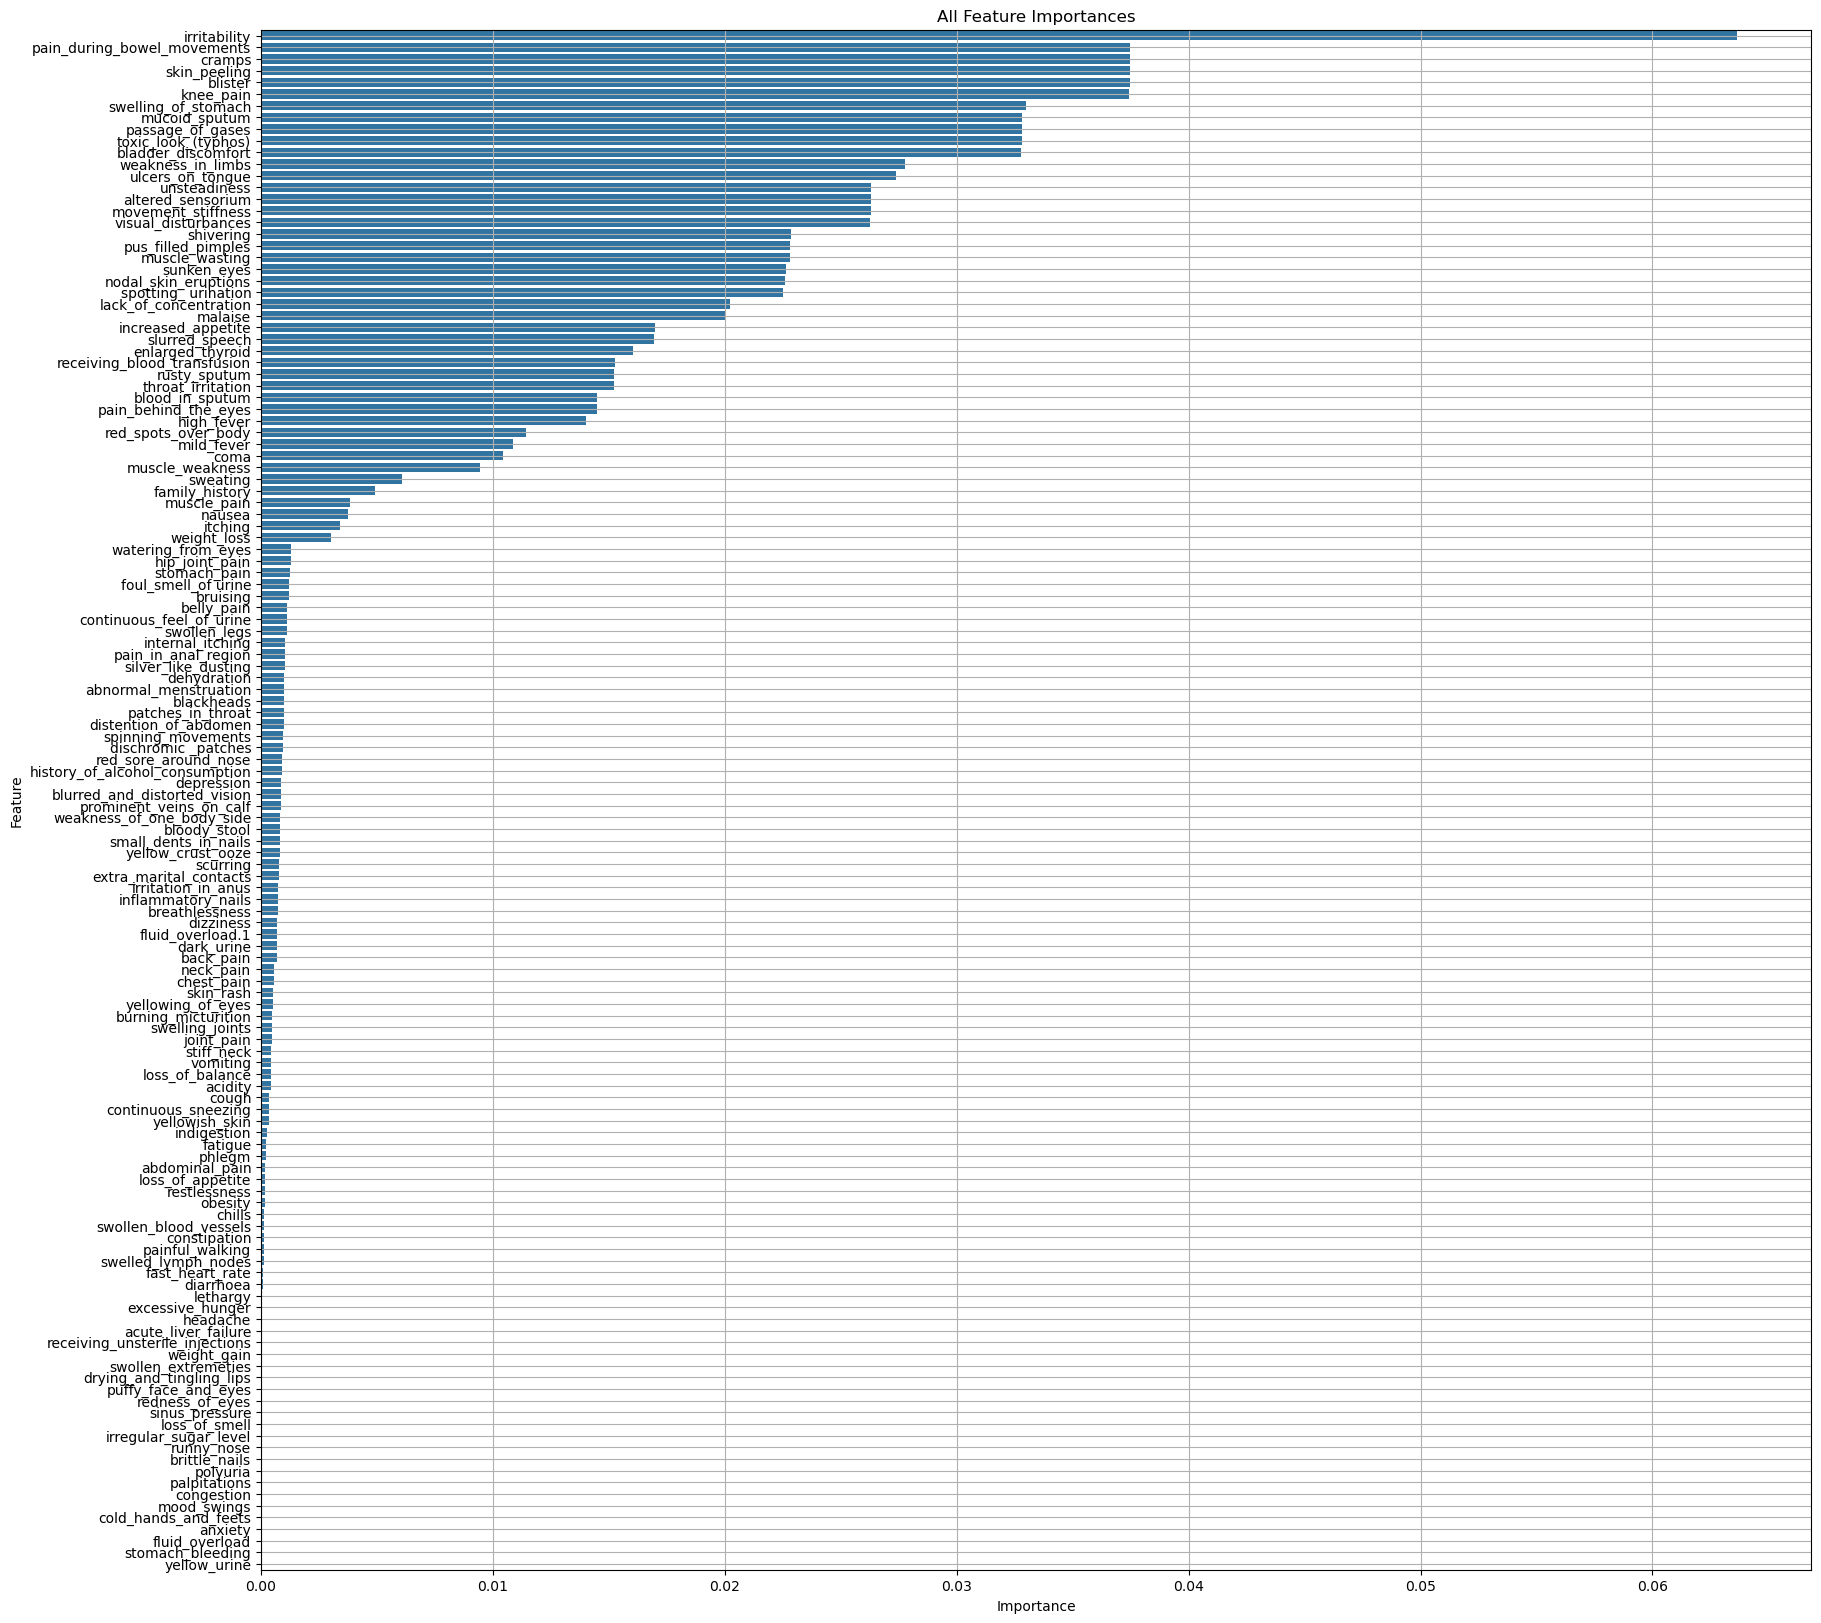

In [11]:
# %%
# Plot Features per importance
plt.figure(figsize=(20,20))
sns.barplot(x='Importance', y= 'Feature', data=feature_importance_df)
plt.title('All Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid()
plt.show()

In [12]:
# %%
